In [1]:
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import sklearn.metrics
# run model on 9L that was trained on 12R with random 10x NCR

In [3]:
ROI10R = np.load('ROI10R_bias_corrected.npy') 
ROI11R = np.load('ROI11R_bias_corrected.npy') 
ROI_TEST = np.vstack((ROI10R,ROI11R))
print("Total Number of Cell Regions: ", len(ROI_TEST))

NCR10R = np.load('NCR10R_bias_corrected.npy') 
NCR11R = np.load('NCR11R_bias_corrected.npy') 
NCR_TEST = np.vstack((NCR10R,NCR11R))
print("Number of Non-Cell Regions:",len(NCR_TEST))

NCR_TEST = np.asarray(NCR_TEST)
print(NCR_TEST.shape)

ROI_TEST = np.asarray(ROI_TEST)
print(ROI_TEST.shape)


test = np.vstack((ROI_TEST, NCR_TEST))
#Test Data: 0-956 = cell
#Test Data: 956-10516 = non cell region
print("Number of Items in Test Data: %s" %len(test))
test = np.expand_dims(test, axis=1)
print('Shape of Test Data Vector:', test.shape)

Total Number of Cell Regions:  275
Number of Non-Cell Regions: 2750
(2750, 12, 12, 12)
(275, 12, 12, 12)
Number of Items in Test Data: 3025
Shape of Test Data Vector: (3025, 1, 12, 12, 12)


In [4]:
#m1=torch.load('model2.pt')
# 1. Model Architecture
# INPUT: 
# - 1 x 12 x 12 x 12 image
# CONV1: 3d CONV
# MAXPOOL: 3d MP
# CONV2: 3d CONV
# CONV3: 3d CONV
# FC1: Fully Connected Layer
# FC2: Fully Connected Layer

class M1(nn.Module):
    def __init__(self):
        super(M1, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv3d(1,64, (5,5,5),padding = 2),nn.Dropout(dr)) # in_channel, out_channel, kernel
        self.pool = nn.MaxPool3d((2, 2, 2),2) # kernel, stride
        self.conv2 = nn.Sequential(nn.Conv3d(64, 64, (3,3,3), padding = 1), nn.Dropout(dr)) # in_channel, out_channel, kernel
        self.conv3 = nn.Sequential(nn.Conv3d(64, 64, (3,3,3), padding = 1), nn.Dropout(dr)) # in_channel, out_channel, kernel
        self.fc1 = nn.Sequential(nn.Linear(6*6*6*64,150),nn.Dropout(dr))
        self.fc2 = nn.Sequential(nn.Linear(150,1),nn.Dropout(dr))

    def forward(self,x):
#        print('Input Shape: ', x.shape)
        x = F.relu(self.conv1(x))
#        print('Shape after CONV1: ', x.shape)
        # Conv1 Activation: ReLU
        x = self.pool(x)
#         print('Shape after Maxpool: ', x.shape)
        # Followed by Maxpool
     
        x = F.relu(self.conv2(x))
#         print('Shape after CONV2: ', x.shape)
        # Conv2 Activation: ReLU
        
        x = F.relu(self.conv3(x))
#         print('Shape after CONV3: ', x.shape)
        # Conv3 Activation: ReLU
        
        x = x.reshape(x.size(0),-1)
#         print('Shape after flatten: ', x.shape)
        # flatten vector
              
        x = F.relu(self.fc1(x))
        # FC1 Activation: ReLU
#         print('Shape after FC1: ', x.shape)
        x = self.fc2(x)
        # FC2 Activation: None
#         print('Shape after FC2: ', x.shape)
        m = nn.Sigmoid()
#         print('Shape after Sigmoid Output: ', x.shape)

        x = m(x)
        # Output Activation: Sigmoid
        return x

#Hyperparamters
num_epochs = 200
batch_size = 5
learning_rate = 1e-3
momentum = 0.9
dr = 0.3
weight_decay = 1e-4
m1 = M1()

In [5]:
m1 = M1()
m1.load_state_dict(torch.load('crossvalidation2.pt'))
m1=m1.double()


In [6]:
truelabels = []

for i in range(0,275):
    truelabels.append(1)
for i in range(0,2750):
    truelabels.append(0)

labels=[]
for i in range(0,len(test)):
    w=torch.from_numpy(test[i])
    w = w.unsqueeze(1)
    w= w.double()
    w.shape
    w=m1(w)
    labels.append(w.detach().numpy())
    
truelabels = np.asarray(truelabels)
labels = np.asarray(labels)
labels =labels.squeeze()

In [7]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(truelabels, labels)
#np.save('positivecells.npy',positivecells)

In [8]:
auc = sklearn.metrics.roc_auc_score(truelabels, labels)
print('AUC: %.3f' % auc)

AUC: 0.918


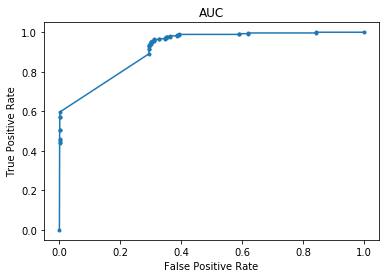

In [9]:
plt.plot(fpr, tpr, marker='.')
plt.title("AUC")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the plot
plt.show()

In [10]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(truelabels, labels)

# calculate F1 score
auc = sklearn.metrics.auc(recall, precision)
auc

0.7920005003663756

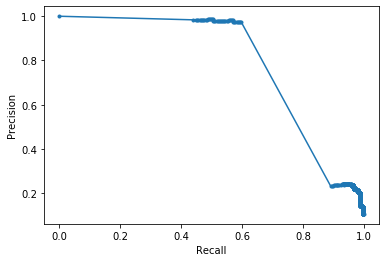

In [11]:
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [12]:
sklearn.metrics.f1_score(truelabels,labels.round())

0.7404063205417607

In [13]:
sklearn.metrics.accuracy_score(truelabels,labels.round())

0.9619834710743802

In [27]:
sklearn.metrics.precision_score(truelabels,labels.round())

0.9761904761904762

In [26]:
ind =[]
for i in range(0,275):
    if labels[i]<.5:
        ind.append(i)

FN_total = np.zeros((len(ind),12,12,12))
for index,i in enumerate(ind):
    FN_total[index]=np.asarray(test[i].squeeze())
print(FN_total.shape)

(30, 12, 12, 12)


In [21]:
#np.save('FN1.npy',np.asarray(FN_total))

519


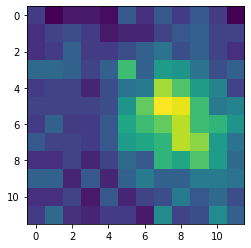

900


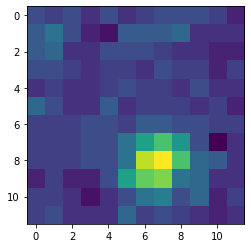

1147


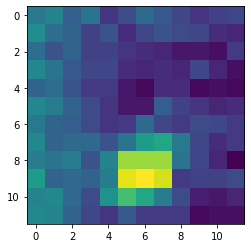

1537


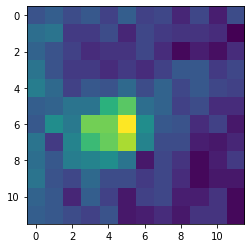

In [22]:
ind=[]
for i in range(275,len(test)):
    if labels[i]>.5:
        ind.append(i)
        print(i)
        plt.imshow(test[i].squeeze()[6,:,:])
        plt.show()
        
FP_total = np.zeros((len(ind),12,12,12))
for index,i in enumerate(ind):
    FP_total[index]=np.asarray(test[i].squeeze())


In [23]:
#np.save('FP1.npy',np.asarray(FP_total))

In [24]:
sklearn.metrics.recall_score(truelabels,labels.round())

0.5963636363636363

In [25]:
len(ind)

4